# EECE-571M Course Project
## Modulation Classification Using Neural Networks
### Submission by Akshay Viswakumar (#32971665)

## DNN Based Solution

### 0. Acquire Data

This section is just to download the RadioML2016.10a Dataset in case it is not present in the current directory.

In [1]:
# Download the dataset from opensig

# Note: If the RML2016.10a.tar.bz2 file is in the same directory as this notebook, the file will not be downloaded again.

from pathlib import Path
dset = Path("RML2016.10a.tar.bz2")

# Check if the File Exists

if(not dset.is_file()):
    import urllib.request
    urllib.request.urlretrieve('http://opendata.deepsig.io/datasets/2016.10/RML2016.10a.tar.bz2', 'RML2016.10a.tar.bz2')

In [2]:
# Decompress the RML2016.10a.tar.bz2 file into RML2016.10a.tar file

# Note: If the RML2016.10a.tar file exists, then this operation is skipped.

import sys
import os
import bz2

tarfile = Path("RML2016.10a.tar")

# Check if the Tar File Exists

if(not tarfile.is_file()):
    zipfile = bz2.BZ2File('./RML2016.10a.tar.bz2') # open the file
    data = zipfile.read() # get the decompressed data
    #write the .tar file
    open('./RML2016.10a.tar', 'wb').write(data) # write a uncompressed file

In [3]:
# Extract the .tar file to get RML2016.10a_dict.pkl

# Note: If the RML2016.10a.tar file exists, then this operation is skipped.

import tarfile

pklFile = Path("RML2016.10a_dict.pkl")

# Check if the pkl File Exists

if(not pklFile.is_file()):
    my_tar = tarfile.open('./RML2016.10a.tar')
    my_tar.extractall('./') # specify which folder to extract to
    my_tar.close()

### 1. Extract the Pickle File and Load Dataset



In [4]:
# Extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open("RML2016.10a_dict.pkl",'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

### 2. Import Required Packages

In [5]:
# Import Necessary Packages
%matplotlib inline
import os
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, LayerNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
import numpy as np

### 3. Data Pre-Processing

Split data into a training, testing and validation sets.

In [6]:
random.seed(777)     # To ensure that the dataset is split in a deterministic way.
np.random.seed(777)  # To ensure that the dataset is split in a deterministic way.

# This section of the code shuffles and splits the into Training, Testing and Validation Sets.

index = np.arange(0,220000)
random.shuffle(index)

trainIdx = index[0:110000]
testIdx = index[110000:220000]

trainX = X[trainIdx]

# Create Validation Data Set
indexVal = np.arange(0,110000)
random.shuffle(indexVal)

realTrainIdx = indexVal[0:99000] 
valIdx = indexVal[99000:110000]

# Training Data
realTrainX = trainX[realTrainIdx]
X_trainDNN = realTrainX # For DNN
X_trainCNN = np.expand_dims(realTrainX, axis=-1) # For CNN

# Validation Data
validX = trainX[valIdx]
X_validDNN = validX # For DNN
X_validCNN = np.expand_dims(validX, axis=-1) # For CNN

# Actual Testing Data
testX = X[testIdx]
X_testDNN = testX # For DNN
X_testCNN = np.expand_dims(testX, axis=-1) # For CNN

# This Section of the code Prepapres labels Using One-Hot Encoding
# One Hot Encode Labels
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
ytrain=lbl_encoded[trainIdx]

# Labels for Training Data
y_train = ytrain[realTrainIdx]

# Labels for Validation Data
y_valid = ytrain[valIdx]

# Labels for Testing Data
y_test=lbl_encoded[testIdx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


### 4. DNN Based Solution

Section 4 will deal with the following 

- 4.1. Prepare the feature vector 
- 4.2. Construct the DNN Model Using Keras
- 4.3. Train the model.
- 4.4. Test trained model on Test Dataset
- 4.5. Visualize Results

### 4.1 Preparing the Feature Vector

In [7]:
# Helper Methods for Feature Extraction

# Function To Compute Raw-Moment of Data
def rawMoment(data,n):
    # Calculate the nth Raw Moment of The Data
    dataRaised = np.power(data,n)
    nthMoment = np.array([np.mean(dataRaised,axis=1)])
    
    return nthMoment.T

# Function To Compute (x+y)th Order Moment
def highOrdMoment(data,x,y):
    complexData = data[:,0,:]+(1j*data[:,1,:]) # Data In Complex Form
    complexDataConj = np.conj(complexData) # Complex Conjugate
    
    finDat = np.power(complexData,x-y)*np.power(complexDataConj,y)
    
    finDatMean = np.array([np.mean(finDat,axis=1)]).T
    
    return finDatMean

# Feature Extraction Methods

# Feature 1: Cumulant C20
def getC20(data):
    m20 = highOrdMoment(data,2,0)
    return np.abs(m20)

# Feature 2: Cumulant C21
def getC21(data):
    m21 = highOrdMoment(data,2,1)
    return np.abs(m21)

# Feature 3: Cumulant C40
def getC40(data):
    m40 = highOrdMoment(data,4,0)
    m20 = highOrdMoment(data,2,0)
    c40 = m40 - (3*np.square(m20))
    
    return np.abs(c40)
    
# Feature 4: Cumulant C41
def getC41(data):
    m41 = highOrdMoment(data,4,1)
    m21 = highOrdMoment(data,2,1)
    m20 = highOrdMoment(data,2,0)
    
    c41 = m41 - (3*m20*m21)
    
    return np.abs(c41)
    
# Feature 5: Cumulant C42
def getC42(data):
    m42 = highOrdMoment(data,4,2)
    m21 = highOrdMoment(data,4,2)
    m20 = highOrdMoment(data,2,0)
    
    c42 = m42 - np.square(m20) - (2*np.square(m21))
    
    # Norm Code
    c21 = getC21(data)
    c42Norm = c42 / np.square(c21)
    
    return np.abs(c42Norm)

# Feature 6: Cumulant C63
def getC63(data):
    m63 = highOrdMoment(data,6,3)
    m20 = highOrdMoment(data,2,0)
    m21 = highOrdMoment(data,2,1)
    m22 = highOrdMoment(data,2,2)
    m40 = highOrdMoment(data,4,0)
    m41 = highOrdMoment(data,4,1)
    m42 = highOrdMoment(data,4,2)
    
    t1 = m63 - (9*m21*m42) + (12*np.power(m21,3))
    #t2 = (-3*m20*m42)-(3*m22*m41)
    #t3 = 18*m20*m21*m22
    
    t2 = (-6*m20*m40) + (18*np.square(m20)*m21) 
    
    #c63 = t1+t2+t3
    c63 = t1+t2
    
    return np.abs(c63)

# Feature 7: Cumulant C80
def getC80(data):
    m80 = highOrdMoment(data,8,0)
    m60 = highOrdMoment(data,6,0)
    m40 = highOrdMoment(data,4,0)
    m20 = highOrdMoment(data,2,0)
    
    t1 = m80 - (35*np.square(m40))
    t2 = (-28*m60*m20) + (420*m40)
    t3 = (-630*np.power(m20,4))
    
    c80 = t1+t2+t3
    
    return np.abs(c80)

# Feature 8: Kurtosis
def getKurtosis(data):
    complexData = data[:,0,:]+(1j*data[:,1,:]) # Data In Complex Form
    meanComplexData = np.array([np.mean(complexData,axis=1)]).T
    
    # Find fourth central moment
    fourthPower = np.power(complexData - meanComplexData,4)
    centralMoment4 = (np.array([np.sum(fourthPower,axis=1)]).T)/fourthPower.shape[1]
    
    # Variance
    var = np.array([np.var(complexData,axis=1)]).T
    
    kurt = np.abs(centralMoment4)/(np.square(var))
    
    return kurt

# Feature 9: Skewness
def getSkewness(data):
    complexData = data[:,0,:]+(1j*data[:,1,:]) # Data In Complex Form
    meanComplexData = np.array([np.mean(complexData,axis=1)]).T
    
    # Find third central moment
    thirdPower = np.power(complexData - meanComplexData,3)
    centralMoment3 = (np.array([np.sum(thirdPower,axis=1)]).T)/thirdPower.shape[1]
    
    # Standard Deviation
    std = np.array([np.std(complexData,axis=1)]).T
    
    skew = np.abs(centralMoment3)/(np.power(std,3))
    
    return skew

# Feature 10: Peak to RMS Power Ratio
def getPR(data):
    complexData = data[:,0,:]+(1j*data[:,1,:]) # Data In Complex Form
    absSquare = np.square(np.abs(complexData))
    absSquareMax = np.array([np.max(absSquare,axis=1)]).T
    
    # Calculate RMS (without Root)
    rms = np.array([np.mean(absSquare,axis=1)]).T 
    
    # Calculate PR
    PR = absSquareMax/rms
    
    return PR

# Feature 11: Peak to Average Power Ratio
def getPA(data):
    complexData = data[:,0,:]+(1j*data[:,1,:]) # Data In Complex Form
    absData = np.abs(complexData)
    absMax = np.array([np.max(absData,axis=1)]).T
    
    # Calculate Mean
    meanData = np.array([np.mean(absData,axis=1)]).T
    
    # Calculate PA
    PA = absMax / meanData
    
    return PA

# Function to Compute Features and Compile Feature Vector
def createIPVector(data):
    cumulantC20 = getC20(data)
    cumulantC21 = getC21(data)
    cumulantC40 = getC40(data)
    cumulantC41 = getC41(data)
    cumulantC42 = getC42(data)
    cumulantC63 = getC63(data)
    cumulantC80 = getC80(data)
    
    kurtosis = getKurtosis(data)
    skewness = getSkewness(data)
    
    pr = getPR(data)
    pa = getPA(data)

    # Concat
    xtrainIP = np.concatenate((cumulantC20,cumulantC21,cumulantC40,cumulantC41,cumulantC42,cumulantC63,cumulantC80,kurtosis,skewness,pr,pa),axis=1)
    return xtrainIP

#### Feature Vectors for DNN Are Created Here

In [8]:
# Generate Input Feature Vector

# Generate Training, Validation and Testing Input Vectors
xtrainIP = createIPVector(realTrainX)

xvalidIP = createIPVector(validX)

xtestIP = createIPVector(testX)

### 4.2 Construct the DNN Model Using Keras

In [9]:
# Network Design Parameters

# Structure
numInput = 11  # Number of Input Nodes
numHid1 = 4096 # Number of Nodes in the First Hidden Layer
numHid2 = 2048 # Number of Nodes in the Second Hidden Layer
numHid3 = 1024 # Number of Nodes in the Third Hidden Layer
numOutput = 11 # Number of Output Nodes

# Activation Functions
activationHidden = 'relu'
activationOutput = 'softmax'

# Loss Function
lossFunction = 'categorical_crossentropy'

# Learning Algorithm
netOptimizer = 'adam'

# Callbacks - Implements Early Stopping and Weight Backup
callbackList = [
        tensorflow.keras.callbacks.ModelCheckpoint('DNN-AV-Weights_best.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='auto')]

# Construct Network
modelDNN = models.Sequential()
modelDNN.add(Dense(numHid1,input_shape=(numInput,), activation=activationHidden, name='Hidden_Layer_1'))
modelDNN.add(Dropout(0.5))
modelDNN.add(Dense(numHid2, activation=activationHidden, name='Hidden_Layer_2'))
modelDNN.add(Dropout(0.5))
modelDNN.add(Dense(numHid3, activation=activationHidden, name='Hidden_Layer_3'))
modelDNN.add(Dropout(0.5))
modelDNN.add(Dense(numOutput, activation=activationOutput, name='Output_Layer'))
modelDNN.compile(loss=lossFunction, optimizer=netOptimizer,metrics=['categorical_accuracy'])
modelDNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer_1 (Dense)       (None, 4096)              49152     
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 2048)              8390656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
Output_Layer (Dense)         (None, 11)                1

### 4.3 Train DNN Model

In [10]:
# Train Model
historyDNN = modelDNN.fit(xtrainIP, y_train, batch_size=1000, epochs=100, verbose=2, validation_data=(xvalidIP,y_valid),callbacks=callbackList)

Train on 99000 samples, validate on 11000 samples
Epoch 1/100
99000/99000 - 7s - loss: 1.9615 - categorical_accuracy: 0.2948 - val_loss: 1.7295 - val_categorical_accuracy: 0.3875
Epoch 2/100
99000/99000 - 5s - loss: 1.7211 - categorical_accuracy: 0.3797 - val_loss: 1.6844 - val_categorical_accuracy: 0.3951
Epoch 3/100
99000/99000 - 5s - loss: 1.6950 - categorical_accuracy: 0.3882 - val_loss: 1.6616 - val_categorical_accuracy: 0.4064
Epoch 4/100
99000/99000 - 5s - loss: 1.6829 - categorical_accuracy: 0.3914 - val_loss: 1.6535 - val_categorical_accuracy: 0.4052
Epoch 5/100
99000/99000 - 4s - loss: 1.6714 - categorical_accuracy: 0.3949 - val_loss: 1.6557 - val_categorical_accuracy: 0.4028
Epoch 6/100
99000/99000 - 5s - loss: 1.6653 - categorical_accuracy: 0.3967 - val_loss: 1.6453 - val_categorical_accuracy: 0.4075
Epoch 7/100
99000/99000 - 4s - loss: 1.6590 - categorical_accuracy: 0.3991 - val_loss: 1.6455 - val_categorical_accuracy: 0.4027
Epoch 8/100
99000/99000 - 5s - loss: 1.6575 - c

In [12]:
# Backupistory for Plotting Outputs

np_loss_history = np.array(historyDNN.history["loss"])
np.save('DNN-lossHist.npy',np_loss_history)

np_accu_history = np.array(historyDNN.history["categorical_accuracy"])
np.save('DNN-accuHist.npy',np_accu_history)

np_val_loss_history = np.array(historyDNN.history["val_loss"])
np.save('DNN-valLossHist.npy',np_val_loss_history)

np_val_accu_history = np.array(historyDNN.history["val_categorical_accuracy"])
np.save('DNN-valAccuHist.npy',np_val_accu_history)

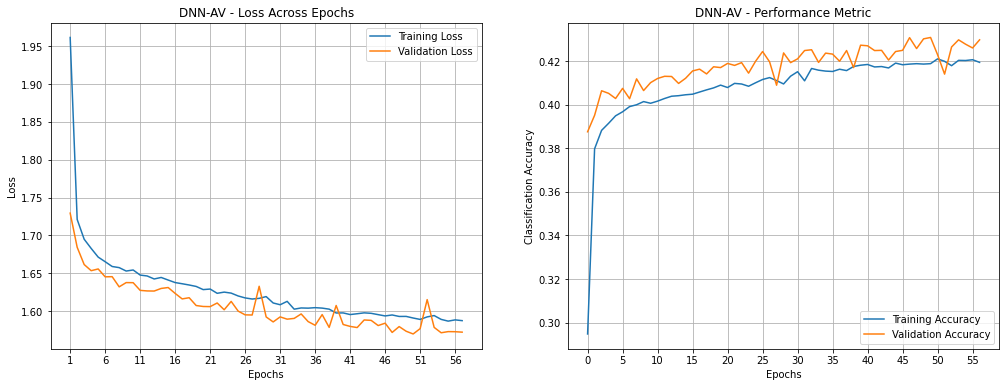

In [16]:
# Plots The Loss and Acuracy Curves from Testing
# Load Recently Backed-Up Details of History
lHistDNN = np.load('DNN-lossHist.npy')
aHistDNN = np.load('DNN-accuHist.npy')

vLHistDNN = np.load('DNN-valLossHist.npy')
vAHistDNN = np.load('DNN-valAccuHist.npy')

# Show loss curves 
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(17, 6))
ax1.set_title('DNN-AV - Loss Across Epochs')
ax1.plot(lHistDNN, label='Training Loss')
ax1.plot(vLHistDNN, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_xticks(np.arange(0,len(lHistDNN)+1,5), minor=False)
ax1.set_xticklabels(np.arange(1,len(lHistDNN)+1,5), fontdict=None, minor=False)
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()
               
ax2.set_title('DNN-AV - Performance Metric')
ax2.plot(aHistDNN, label='Training Accuracy')
ax2.plot(vAHistDNN, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_xticks(np.arange(0,len(lHistDNN),5), minor=False)
ax2.set_xticklabels(np.arange(0,len(lHistDNN),5), fontdict=None, minor=False)
ax2.set_ylabel('Classification Accuracy')
ax2.grid()
ax2.legend(loc='lower right')

### 4.4 Test DNN Model on Testing Dataset

During training, the weights yielding the least validation loss have been stored. This is reloaded into the model. Then we evaluate the network performance using the test dataset.

In [17]:
# Re-load Best Weights from Training
modelDNN.load_weights('DNN-AV-Weights_best.h5')

# Evaluate Test Dataset Using Trained DNN Model
modelDNN.evaluate(xtestIP,y_test)

110000/110000 [==============================] - 25s 229us/sample - loss: 1.5658 - categorical_accuracy: 0.4255


[1.565834234861894, 0.42554545]

### 4.5 Visualize Results

In [18]:
# Helper Functions to Plot Confusion Matrix

# Function to Extract Test Data of Specific SNR
def extractTest(data,labels,labelsEncoded,testIndex,snr):
    testData = data[testIndex]
    labelArray = np.array([labels])
    testLabels = labelArray[:,testIdx,:]
    testLabelsEncoded = labelsEncoded[testIdx]
    
    idxOP = list()
    
    # Loop Through Label Array To Get Index of Specific SNR
    for i in range(0,testLabels.shape[1]):
        if testLabels[0,i,1].decode('ascii')==snr:
            idxOP.append(i)
    
    # Return Subset of Test Data and Corresponding Labels
    opTestData = testData[idxOP,:,:]
    opTestLabel = testLabelsEncoded[idxOP]
    
    return opTestData, opTestLabel

def plot_confusion_matrix(cm, titleAdd, title='DNN-AV - Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title+titleAdd)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Confusion Matrix Function
def prepConfMat(testData,testLabel,predTestLabel,mods,title):
    modString = list()
    for i in range(0,len(mods)):
        modString.append(mods[i].decode('ascii'))
    
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,testData.shape[0]):
        j = list(testLabel[i,:]).index(1)
        k = int(np.argmax(predTestLabel[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plot_confusion_matrix(confnorm, title, labels=modString)

#### Plot Confusion Matrix for All SNRs

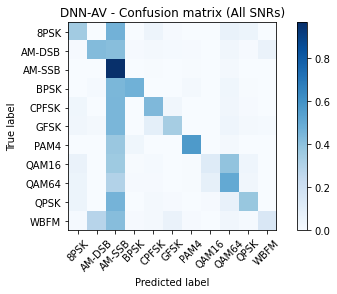

In [21]:
# Plot confusion matrix

test_Y_hatDNN = modelDNN.predict(xtestIP, batch_size=1024)

prepConfMat(xtestIP,y_test,test_Y_hatDNN,mods,' (All SNRs)')

#### Plot Confusion Matrix for Specific SNRs

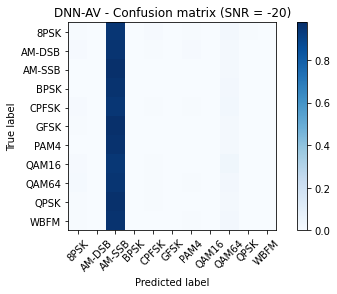

In [24]:
snr = '-20'
title = ' (SNR = '+snr+')'
x_testSNR, y_TestSNR = extractTest(X,lbl,lbl_encoded,testIdx,snr)
xtestSNRFeat = createIPVector(x_testSNR)

y_hat_snr = modelDNN.predict(xtestSNRFeat, batch_size=1024)
prepConfMat(xtestSNRFeat,y_TestSNR,y_hat_snr,mods,title)

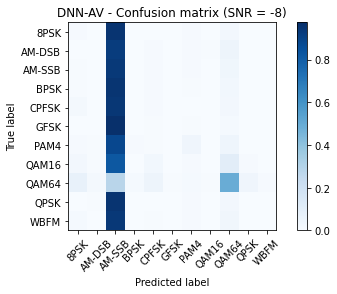

In [25]:
snr = '-8'
title = ' (SNR = '+snr+')'
x_testSNR, y_TestSNR = extractTest(X,lbl,lbl_encoded,testIdx,snr)
xtestSNRFeat = createIPVector(x_testSNR)

y_hat_snr = modelDNN.predict(xtestSNRFeat, batch_size=1024)
prepConfMat(xtestSNRFeat,y_TestSNR,y_hat_snr,mods,title)

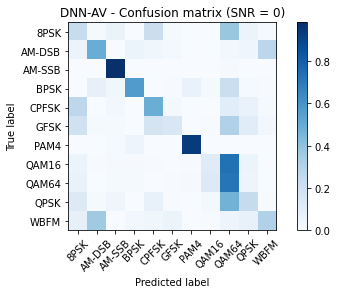

In [26]:
snr = '0'
title = ' (SNR = '+snr+')'
x_testSNR, y_TestSNR = extractTest(X,lbl,lbl_encoded,testIdx,snr)
xtestSNRFeat = createIPVector(x_testSNR)

y_hat_snr = modelDNN.predict(xtestSNRFeat, batch_size=1024)
prepConfMat(xtestSNRFeat,y_TestSNR,y_hat_snr,mods,title)

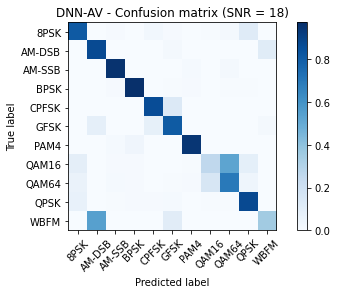

In [27]:
snr = '18'
title = ' (SNR = '+snr+')'
x_testSNR, y_TestSNR = extractTest(X,lbl,lbl_encoded,testIdx,snr)
xtestSNRFeat = createIPVector(x_testSNR)

y_hat_snr = modelDNN.predict(xtestSNRFeat, batch_size=1024)
prepConfMat(xtestSNRFeat,y_TestSNR,y_hat_snr,mods,title)

### Plot Average Accuracy Across All Classes For Each SNR 

Random Guess Accuracy: 0.09090909090909091


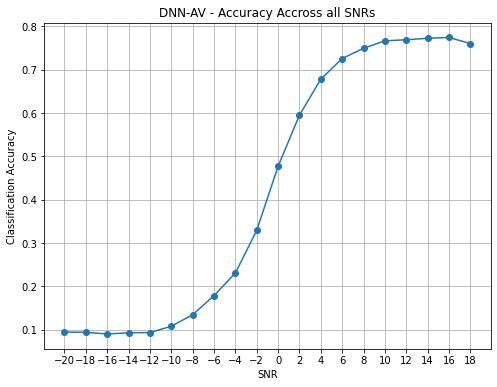

In [29]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []


snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])

y_test_snr=snr_array[testIdx]

for snr in snr_label_array:
    test_X_i_temp = testX[np.where(y_test_snr==snr)]
    test_X_i = createIPVector(test_X_i_temp)
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = modelDNN.predict(test_X_i)
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))

print("Random Guess Accuracy:",1/11)

# Show loss curves 
plt.figure(figsize=(8, 6))
plt.title('DNN-AV - Accuracy Accross all SNRs')
plt.plot(np.arange(-20,20,2), acc_array,marker='.',markersize=12)
plt.xlabel('SNR')
plt.xticks(np.arange(-20,20,2))
plt.ylabel('Classification Accuracy')
plt.grid()
plt.show()